<img src="./img/DSME_logo.png" alt="Scoring probabilities for direct shots [2]" width="1000">

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Bonus Point Assignment 1 - Task 2: Double-Q Learning

*Important: Place your answer in fields marked for this purpose and do not modify any of the cells. In case anything outside the answer fields has been modified, we recommend restarting the notebook.*

## Library Imports

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import custom_envs
from render_util import visualize, plot_action_value
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import Video
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Task Description

Often we don't know the environment dynamics a-priori, which hinders us from applying dynamic programming methods. Here, reinforcement learning approaches like Q-learning can help [1]. As we know from lecture, Q-learning gradually adapts its estimate of the action value function based on data observed using temporal difference (TD) learning. The off-policy nature of Q-learning results in a TD target formulated with respect to the greedy target policy, making it dependent on the highest action value for the next state [2]. In noisy setups, e.g. when the reward emitted by the environment is noisy or function approximation is used to represent the Q-function, this can lead to overestimation bias of the Q-function [3].

Double Q-learning mitigates this issue by learning two Q-functions, seperating the process of action selection and it's evaluation in the computation of the TD target [4]. This way, overestimation occurs less, and better performance can be demonstrated in some scenarios. An example is shown below.  

<img src="./img/maximization_bias.png" alt="Effect of the Maximization Bias in Q-Learning [5]" width="735">   

The authors of [5] show that for a simple MDP, as shown in the upper-right corner, double Q-learning converges to the optimal solution much faster. For further details on the example, we refer to [5]. The performance was achieved by using an algorithm following the description presented below on the left. Here, the policy is chosen randomly. However, a different logic can be used for the selection of the respective Q-function. Nevertheless, we will follow the proposed logic in [5].    

<div style="clear: both;">
  <table style="float: left;">
    <tr>
      <td> <img src="./img/double_q_learning.png" alt="Algorithm for Double Q-Learning [5]" width="535"> </td>
      <td> <img src="./img/UML_DoubleQ.png" alt="UML Agent" width="200"> </td>
    </tr>
  </table>
  <p style="clear: both;">
  </p>
</div>  

We can observe many similarities to Q-learning. For an easier understanding, we use the term “learning_rate” instead of &alpha; in the course of this task.
Your task is to implement the algorithm above in a class `Agent`, as shown in the diagram above on the right. We will test the ability of the algorithm to solve reinforcement learning tasks in the “FrozenLake” environment [6], with some modifications. In particular, we prevent the agent from “sliding” around by setting the probability of moving in the intended direction to 100%. The goal is for the elve to move to the package without entering an ice hole. For an example of the environment, see below. 

<img src="./img/frozen_lake.gif" alt="Example of Frozen_Lake [6]" width="380">   

First, we design the Q-functions in task 2.1, followed by the policies in task 2.2 and the training method in task 2.3. Finally, in task 2.4, we create a method to train and evaluate the agent in an environment.  


[1] Watkins, C.J.C.H. "Learning from delayed rewards." PhD Thesis, University of Cambridge, England (1989).  
[2] Watkins, C.J.C.H., Dayan, P. Q-learning. Mach Learn 8, 279–292 (1992). [Link](https://link.springer.com/article/10.1007/BF00992698)  
[3] Thrun, Sebastian, and Anton Schwartz. "Issues in using function approximation for reinforcement learning." Proceedings of the 1993 connectionist models summer school. Psychology Press, 2014. [Link](https://www.taylorfrancis.com/chapters/edit/10.4324/9781315806433-38/issues-using-function-approximation-reinforcement-learning-sebastian-thrun-anton-schwartz)  
[4] Hasselt, Hado. "Double Q-learning." Advances in neural information processing systems 23 (2010) [Link](https://papers.nips.cc/paper_files/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html)  
[5] Sutton, Richard S., and Andrew G. Barto, "Temporal Difference Learning", in *Reinforcement learning: An introduction*.  MIT press, 2018.  
[6] Towers, Mark and Terry "Gymnasium." Farama Foundation 2023. [Link](https://gymnasium.farama.org/index.html#)

---

## Task 2.1 (1 Point)   

We will now start with the basics by implementing all relevant variables in `__init__`. All variables used in the algorithm (see above) should be included. In particular, the two Q-functions named `self.q_1` and `self.q_2` should be implemented as NumPy arrays. We initialize all values of the Q-functions with a value of 0.

*Hint: Each environment has different quantities and names for its actions and states. To generalise this, states and actions are assigned integers in Gymnasium. The maximum number can be taken from `env.observation_space.n` and `env.action_space.n`*.

### Student Answer

In [2]:
class Agent():
    def __init__(self, env, gamma=1.0, learning_rate=0.05, epsilon=0.1):
        """ Initializes the environment and defines dynamics.
        
        Please DON'T change the names of the variables that are already defined in this method.
        The Q-functions shall be called 'self.q_1' and 'self.q_2', besides, there exist 'self.env', 'self.learning_rate', 
        'self.gamma' and 'self.epsilon'
        """
        self.env = env

        # YOUR CODE HERE
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        n_states = self.env.observation_space.n
        n_actions = self.env.action_space.n
        empty_array = np.zeros(shape=(n_states, n_actions))
        self.q_1 = empty_array
        self.q_2 = empty_array


### Checkpoint

In [3]:
# Do we have both Q-Functions?

map = ["SFFH", "FFFH", "HFFH", "HFFG"]
test_env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False) 
test_agent = Agent(test_env, gamma=1.0, learning_rate=0.05, epsilon=0.1)
assert test_agent.q_1[0][0] != None
assert test_agent.q_2[0][0] != None

In [4]:
# Used for grading. Do not change.

---

## Task 2.2 (1 Point)   

At this point, we still lack methods to extract actions from the Q-functions of our agent. Implementing these methods effectively creates policies that allow the agent to interact with the environment. Your task is to implement these methods. In particular, we need two different methods:
* a greedy method that returns the best possible action given an observation and a Q-function.
* an epsilon-greedy method that, given the same input, sometimes returns a random output based on the probability `self.epsilon`.

Passing a Q-function is important here, as it allows us to extract values from one or both Q-functions. We already implemented the greedy method below, called `get_best_action`. However, we still miss a method `epsilon_greedy_policy`. Please implement it below, following the description for epsilon-greedy policies as given in the lecture. 

*Hint: You can use `np.random.random()` for for taking random actions.*

*Remark: We chose an implicit definition of the policies; however, one could also use a more explicit definition by creating objects for the policies if desired. Thus, the implementation used in this task is only one of many possible ways to implement the interaction between agent and environment.*

### Student Answer

In [5]:
def get_best_action(self, obs, q):
    """ Return the best action based on the Q-function.
    
    Args: 
        obs: state of the environment
        q: The chosen Q-Function, a numpy array of shape (num_states, num_actions)
    Returns:
        best_action: Chosen action
    """
    
    best_action = np.random.choice(np.flatnonzero(np.isclose(q[obs], (q[obs]).max(), rtol=0.01)))
    return best_action

def epsilon_greedy_policy(self, obs, q):
    """ Return an action based on the Q-function and probability self.epsilon.
    
    The action should be random with probability self.epsilon, or otherwise the best action based on the Q-function.
    
    Args: 
        obs: state of the environment
        q: The chosen Q-Function, a numpy array of shape (num_states, num_actions)
    Returns:
        action: Chosen action
    """

    # YOUR CODE HERE
    #Lecture 4 slide 44
    
    greedy_action_index = get_best_action(self, obs, q)
    number_of_actions = self.env.action_space.n

    greedy_probabilities = []
    for i in range(number_of_actions):
        if i != greedy_action_index:
            probability =  self.epsilon/number_of_actions                 
        else:
            probability =  1 - self.epsilon + (self.epsilon/number_of_actions)                 
        greedy_probabilities.append(probability)

    #make random choice based on distribution defined by probability

    index_choice = np.random.choice(np.arange(0, number_of_actions), p=greedy_probabilities)
    return index_choice
    

In [6]:
setattr(Agent, 'get_best_action', get_best_action)
setattr(Agent, 'epsilon_greedy_policy', epsilon_greedy_policy)

### Checkpoint

In [7]:
# Can we get an action?

test_env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False) 
test_agent = Agent(test_env, epsilon = 0.0)
test_agent.q_1[0][0] = 1
assert test_agent.epsilon_greedy_policy(0, test_agent.q_1) == 0

In [8]:
# Used for grading. Do not change.

---

## Task 2.3 (1 Point)

We can now let the agent and the environment interact with each other. However, we still need to enable our agent to train. To achieve this, we want to implement a method `train` that improves the policy by learning the optimal Q-function. The method only needs the number of episodes to be trained for as input and does not return anything. During a training run, the Q-functions are optimized, thus achieving the optimal policy.

We have already provided a rough structure below. Your task is to add the updates for the two Q-functions, as noted in the algorithm above. In the case of success, you should be able to see the Q-function learning about the environment below. 

*Remark: Since the learning process depends on random variables, it sometimes takes multiple runs of the checkpoint to see improvement in the Q-function.*

### Student Answer

In [9]:
def train(self, num_episodes):
    """ Trains the agent with the double-q algorithm.
    
    Args: 
        num_episodes: Number of episodes used until training stops
    """
    for i in range(num_episodes+1):
        obs, info = self.env.reset()
        done = False
        while not done:
            # In this implementation we only use n=1, but we could extend it for n = ... using a numpy array
            # Choose action and perform step
            action = self.epsilon_greedy_policy(obs, self.q_1 + self.q_2)
            next_obs, reward, done, truncated, info = self.env.step(action)
            # TD Update

            # YOUR CODE HERE
            #print("State:", obs, "Action:", action, "Reward:", reward)
            if random.randint(0,1):
                self.q_1[obs][action] += self.learning_rate * (reward + self.gamma * self.q_2[next_obs][get_best_action(self, next_obs, self.q_1)] - self.q_1[obs][action])                
            else:
                self.q_2[obs][action] += self.learning_rate * (reward + self.gamma * self.q_1[next_obs][get_best_action(self, next_obs, self.q_2)] - self.q_2[obs][action])

            obs = next_obs


In [10]:
setattr(Agent, 'train', train)
setattr(Agent, 'visualize', visualize)
setattr(Agent, 'plot_action_value', plot_action_value)

### Checkpoint

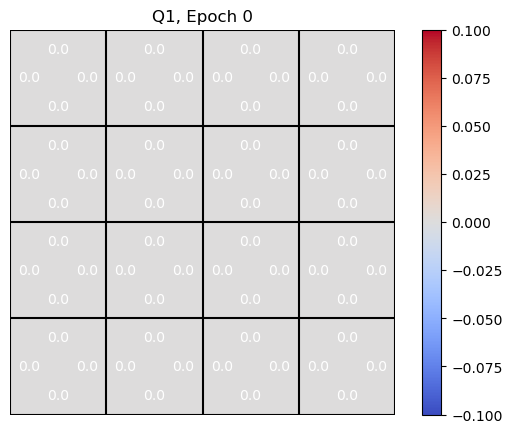

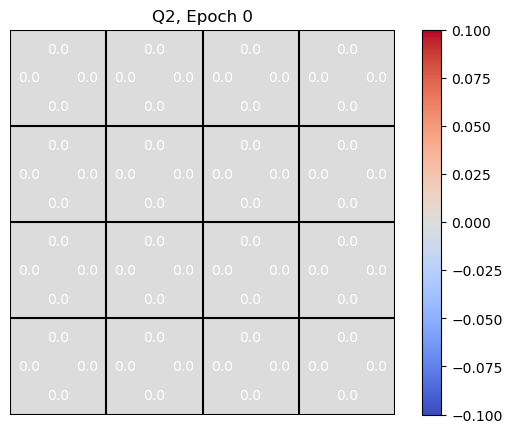

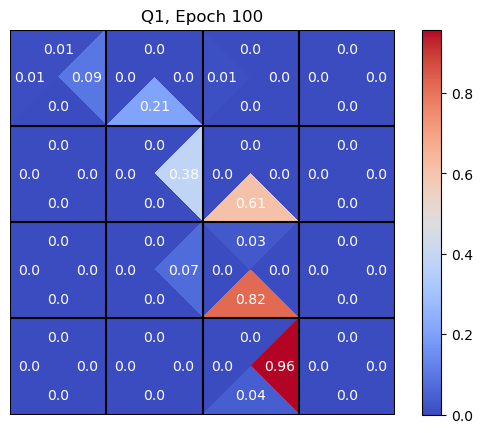

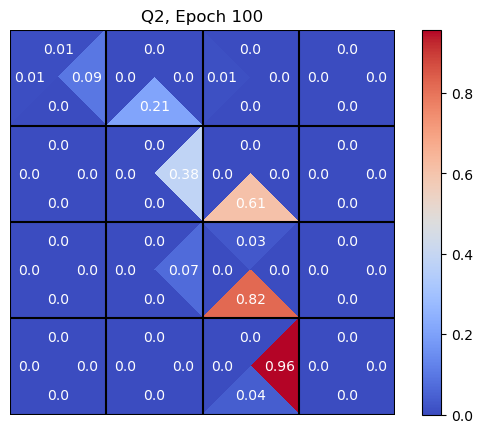

In [11]:
# Does our policy change?

map = ["SFFH", "FFFH", "HFFH", "HFFG"]
test_env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False) 
test_agent = Agent(test_env)
test_agent.visualize(0)
test_agent.train(100)
test_agent.visualize(100)

In [16]:
# Used for grading. Do not change.

---

## Task 2.4 (1 Point)

Now, our agent can train, but we still lack the method to see the results of our training on the ice.  Thus, your task is to implement a method that exploits the experience we acquired during training. This method shall be called `evaluate`. Here, we want to greedily select our actions according to the sum of both Q-functions to obtain an optimal policy. A rough framework for the evaluation, including rendering, is already given below and only needs to be completed. 

*Hint: The environment returns a lot of information via `env.step(action)`, some of which might turn out to be unnecessary. For an overview, we refer to the code in the Gymnasium documentation.*

### Student Answer

In [13]:
def evaluate(self, env, file, num_runs=5):
    """ Evaluates the agent in the environment.

    Args:
        env: Environment we want to use. 
        file: File used for storing the video.
        num_runs: Number of runs displayed
    Returns:
        done: Info about whether the last run is done.
        reward: The reward the agent gathered in the last step.
    """
    frames = []  # collect rgb_image of agent env interaction
    video_created = False
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        out = env.render()
        frames.append(out)
        while not done:
            
            # YOUR CODE HERE
            action = self.get_best_action(obs, self.q_1 + self.q_2)
            obs, reward, done, truncated, info = self.env.step(action)
            
            out = env.render()
            frames.append(out)
                
    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0])
        def animate(index):
            img.set_data(frames[index])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=5)
        
    return done, reward

setattr(Agent, 'evaluate', evaluate)

### Checkpoint

In [15]:
# Can we run evaluate?

map = ["SFFH", "FFGH", "HFFH", "HFFF"]
test_env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False) 
test_agent = Agent(test_env)
test_agent.q_1[0][2] = 1
test_agent.q_1[1][2] = 1
test_agent.q_1[2][2] = 1
# This policy leads the agent to an ice-hole on the right, for a video check the file "test_run.mp4"

test_video = "test_run.mp4"
test_run = test_agent.evaluate(test_env, test_video)[0] 
assert test_run == True

In [ ]:
# Used for grading. Do not change.

---

## Finally: Training the Agent (1 Point)

Lastly, we verify that our agent can train in the selected environment. For this purpose, we create a lake and let the agent train for plenty of episodes. If everything has been implemented according to the task, you should see a video of our agent solving the task successfully without drowning. This is also meant to provide feedback on whether your code is working successfully.

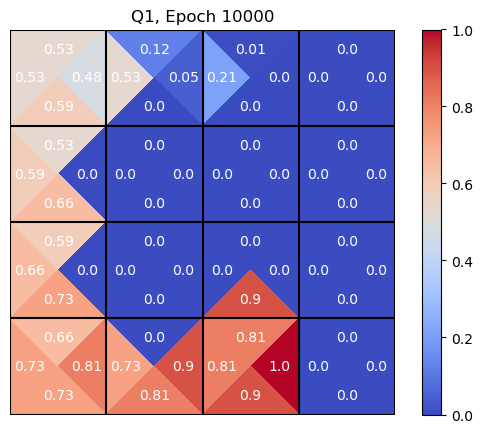

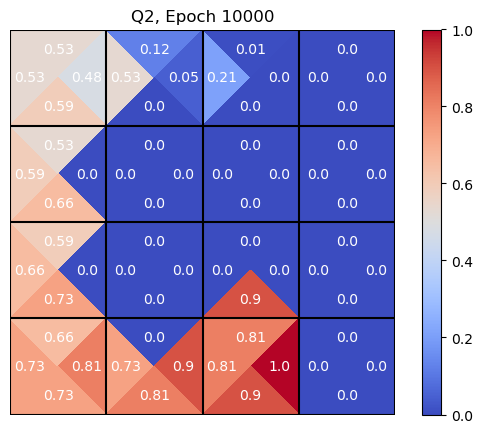

In [16]:
training_runs = 10000
map = ["SFFF", "FHFH", "FHFH", "FFFG"]
env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False) 
env.reset()
final_agent = Agent(env, gamma=0.9)
final_agent.train(training_runs)
final_agent.visualize(training_runs)
video = "final_run.mp4"
final_agent.evaluate(env, video, num_runs=1)
Video(video, html_attributes="loop autoplay")

In [ ]:
# This is the end of task 2, please proceed with task 3